# Building a network

Network construction in NEURON follows the following steps:

1. Prepare neurons (morphology, mechanisms, etc.) and external stimuli if necessary,
2. Embed synapse objects in each neuron,
3. Connect the neurons to the synapses via [NetCon](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html),
4. Set up recordings,
5. Run the simulation.

![](./imgs/net_construction.png)

Here we demonstrate two simple networks with one pyramidal neuron and one or two external stimuli.

## 2. 1 Pyramidal cell + 1 stimulus

Again, we start from importing the NEURON and cell module.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import libcell

cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 
nrn_define_shape: soma first and last 3-d point at same (x,y)


Here we open a session that embeds a synapse object called [Exp2Syn](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=exp2syn#Exp2Syn).

In [2]:
h.xopen("one_syn.ses")

1.0

In [3]:
print('tau1 = {} ms\ntau2 = {} ms'.format(
        h.Exp2Syn[0].tau1, h.Exp2Syn[0].tau2))

tau1 = 0.1 ms
tau2 = 2.0 ms


Again we define our run function:

In [4]:
def run(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(cell.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.c() # Should return a copy of the vector

However, nothing happens during our simulation since there is no input connected to the synapse.

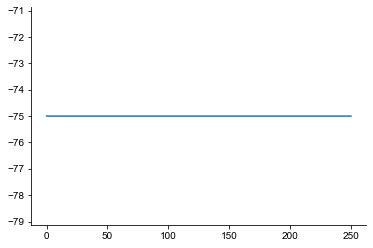

In [5]:
vrec = run()

fig, ax = plt.subplots()
ax.plot(np.arange(2500)*0.1, vrec)

Therefore, we prepare an artificial spike generator called [NetStim](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=netstim#NetStim) and connect this to `h.Exp2Syn[0]` by a `NetCon` object.

In [ ]:
# Check out the documentation for what the parameters are
stim = h.NetStim()
stim.start = 50
stim.number = 5
stim.interval = 5
stim.noise = 0

# Connect stim to our synapse
nc = h.NetCon(stim, h.Exp2Syn[0])

Nothing happens yet since the synaptic conductance is 0. We set this to a non-zero value:

In [ ]:
nc.weight[0] = 0.01 # 0.01 nS = 10 pS of the synaptic conductance

In [ ]:
vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

Now we see EPSPs triggered by spikes from `stim`.

In [ ]:
stim.start = 50
stim.number = 5
stim.interval = 40
stim.noise = 1

## 1 Pyramidal cell + 2 stimuli

Again, we start from importing the NEURON and cell module **after restarting the kernel**:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import libcell

In [ ]:
cell = libcell.L23()

We import a session with two synapses, `h.Exp2Syn[0]` and `h.Exp2Syn[1]`.

In [ ]:
h.xopen("two_syns.ses")

Here we put the spike generators and NetCons in lists:

In [ ]:
stim = []
nc = []
for i in range(2):
    stim.append(h.NetStim())
    stim[i].start = 50
    stim[i].number = 1
    stim[i].noise = 0
    
    nc.append(h.NetCon(stim[i], h.Exp2Syn[i]))
    nc[i].weight[0] = 0.01

In [ ]:
def run(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(h.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.c() # Should return a copy of the vector

In [ ]:
stim[1].start = 150

vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

In [ ]:
sec = h.Exp2Syn[0].get_segment().sec
sec

Here we move the second synapse close to the first, make it inhibitory, slow decaying, and early activating:

In [ ]:
h.Exp2Syn[1].loc(sec(0.1))
h.Exp2Syn[1].e = -75
h.Exp2Syn[1].tau2 = 100

stim[1].start = 100

In [ ]:
vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="time (ms)", ylabel="voltage (mV)")

Note that the EPSP amplitude decreased due to *shunting* by the inhibitory synapse.

## 1 Pyramidal cell + 2 synapses driven by random spike trains

Again, we start from importing the NEURON and cell module **after restarting the kernel**:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import libcell

cell = libcell.L23()

h.xopen("two_syns.ses")

Again, we make the second synapse *inhibitory*:

In [ ]:
h.Exp2Syn[1].e = -76
h.Exp2Syn[1].tau2 = 10

Here we put the spike generators and NetCons in lists:

In [ ]:
stim = []
nc = []
for i in range(2):
    stim.append(h.NetStim())
    stim[i].start = 0
    stim[i].number = 10000
    stim[i].interval = 10 # 10 ms interval -> 1000/10 = 100 Hz firing
    stim[i].noise = 0
    
    nc.append(h.NetCon(stim[i], h.Exp2Syn[i]))
    nc[i].weight[0] = 0.01

In [ ]:
def run(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(h.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.c() # Should return a copy of the vector

In [ ]:
vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="Time (ms)", ylabel="Voltage (mV)")

In [ ]:
for i in range(2):
    stim[i].noise = 1
    stim[i].interval = 5 # 1000/50 = 20 Hz firing

vrec = run(tstop=250)

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="Time (ms)", ylabel="Voltage (mV)")